In [1]:
from model import ModelWithActivations
from torchvision.models import vgg16, squeezenet1_1
import pathlib
from tqdm import tqdm
import torch
import torch.nn as nn
import numbers
import math
import scipy.ndimage as nd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [332]:
from torchmetrics.functional import total_variation
from model import ModelWithActivations
import numpy as np
from typing import Optional, List
from tqdm import tqdm
import torch
import torch.nn.functional as F


def prepare_input_image(input_image: np.ndarray):
    input_image = torch.from_numpy(input_image)
    input_image = torch.unsqueeze(input_image, 0) # minibatch
    input_image.requires_grad = True
    return input_image

def torch_to_numpy(input_image: torch.Tensor):
    input_image = input_image.detach().numpy()
    input_image = np.squeeze(input_image)
    return input_image

def smooth_grad(grad):
    grad_std = torch.std(grad)
    grad_mean = torch.mean(grad)
    grad -= grad_mean
    grad /= grad_std
    return grad

def optimize_image(
    model: ModelWithActivations, 
    image: np.ndarray,
    n_iterations: int = 10,
    target_idx: Optional[int] = None,
    activation_types: Optional[str] = None,
    activation_idxs: Optional[List[int]] = None,
    regularization_coeff: float = 0.1,
    lr: float = 0.1,
    ) -> np.ndarray:
    input_image = prepare_input_image(np.copy(image))
    optimizer = torch.optim.Adam([input_image], lr=lr)
    for _ in tqdm(range(n_iterations)):
        optimizer.zero_grad()
        model(input_image) # just to call forward and calculate activations
        if target_idx is not None:
            activations = model.get_target_activation(target_idx)
        elif activation_types is not None:
            activations = model.get_activations_by_types(activation_types)
        elif activation_idxs is not None:
            activations = model.get_activations_by_idx(activation_idxs)
        else:
            activations = model.get_all_activations()
        losses = [torch.linalg.vector_norm(activation, ord=2) for activation in activations]
        loss = -torch.mean(torch.stack(losses)) 
        regularization = regularization_coeff * total_variation(input_image)
        loss += regularization
        loss.backward()
        optimizer.step()
    optimized_image = input_image.detach().numpy().squeeze()
    return optimized_image
        
        

In [325]:
from PIL import Image
import pathlib
from torchvision import transforms
from typing import Callable
import torch.nn.functional as F
import torch
import numpy as np
from functools import partial
import matplotlib.pyplot as plt


VGG_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        )])

def load_image(path: pathlib.Path, transform: Callable = VGG_TRANSFORM):
    img = Image.open(path)
    img = transform(img)
    img = torch.unsqueeze(img, 0) # (N, C, H, W)
    return img

In [326]:
model = ModelWithActivations(model=vgg16(pretrained=True))
image = np.random.rand(3, 250, 250).astype(dtype=np.float32) #load_image("examples/amazon.jpg")#

In [341]:
processed_image = optimize_image(model, image, n_iterations=30, target_idx=1)

  0%|                                                                                                              | 0/30 [00:00<?, ?it/s]

tensor(-1.2919, grad_fn=<NegBackward0>) tensor(12423.4248, grad_fn=<MulBackward0>)


  3%|███▍                                                                                                  | 1/30 [00:01<00:34,  1.18s/it]

tensor(-3.8190, grad_fn=<NegBackward0>) tensor(8964.7129, grad_fn=<MulBackward0>)


  7%|██████▊                                                                                               | 2/30 [00:02<00:32,  1.18s/it]

tensor(-4.2827, grad_fn=<NegBackward0>) tensor(6299.4429, grad_fn=<MulBackward0>)


 10%|██████████▏                                                                                           | 3/30 [00:03<00:30,  1.13s/it]

tensor(-4.8899, grad_fn=<NegBackward0>) tensor(4612.4526, grad_fn=<MulBackward0>)


 13%|█████████████▌                                                                                        | 4/30 [00:04<00:29,  1.12s/it]

tensor(-5.7007, grad_fn=<NegBackward0>) tensor(3851.1980, grad_fn=<MulBackward0>)


 17%|█████████████████                                                                                     | 5/30 [00:05<00:27,  1.09s/it]

tensor(-8.3303, grad_fn=<NegBackward0>) tensor(3740.4734, grad_fn=<MulBackward0>)


 20%|████████████████████▍                                                                                 | 6/30 [00:06<00:26,  1.11s/it]

tensor(-11.7391, grad_fn=<NegBackward0>) tensor(3762.2146, grad_fn=<MulBackward0>)


 23%|███████████████████████▊                                                                              | 7/30 [00:07<00:26,  1.15s/it]

tensor(-16.4382, grad_fn=<NegBackward0>) tensor(3676.6492, grad_fn=<MulBackward0>)


 27%|███████████████████████████▏                                                                          | 8/30 [00:09<00:25,  1.17s/it]

tensor(-19.0138, grad_fn=<NegBackward0>) tensor(3487.7156, grad_fn=<MulBackward0>)


 30%|██████████████████████████████▌                                                                       | 9/30 [00:10<00:24,  1.15s/it]

tensor(-21.4622, grad_fn=<NegBackward0>) tensor(3224.7571, grad_fn=<MulBackward0>)


 33%|█████████████████████████████████▋                                                                   | 10/30 [00:11<00:22,  1.13s/it]

tensor(-23.4738, grad_fn=<NegBackward0>) tensor(2921.7910, grad_fn=<MulBackward0>)


 37%|█████████████████████████████████████                                                                | 11/30 [00:12<00:21,  1.13s/it]

tensor(-26.4927, grad_fn=<NegBackward0>) tensor(2622.3684, grad_fn=<MulBackward0>)


 40%|████████████████████████████████████████▍                                                            | 12/30 [00:13<00:19,  1.10s/it]

tensor(-29.6653, grad_fn=<NegBackward0>) tensor(2365.6201, grad_fn=<MulBackward0>)


 43%|███████████████████████████████████████████▊                                                         | 13/30 [00:14<00:18,  1.10s/it]

tensor(-33.0168, grad_fn=<NegBackward0>) tensor(2176.5625, grad_fn=<MulBackward0>)


 47%|███████████████████████████████████████████████▏                                                     | 14/30 [00:15<00:17,  1.08s/it]

tensor(-35.9044, grad_fn=<NegBackward0>) tensor(2047.9600, grad_fn=<MulBackward0>)


 50%|██████████████████████████████████████████████████▌                                                  | 15/30 [00:16<00:16,  1.10s/it]

tensor(-40.5764, grad_fn=<NegBackward0>) tensor(1956.4844, grad_fn=<MulBackward0>)


 53%|█████████████████████████████████████████████████████▊                                               | 16/30 [00:17<00:15,  1.09s/it]

tensor(-45.4040, grad_fn=<NegBackward0>) tensor(1875.6512, grad_fn=<MulBackward0>)


 57%|█████████████████████████████████████████████████████████▏                                           | 17/30 [00:19<00:14,  1.13s/it]

tensor(-49.0476, grad_fn=<NegBackward0>) tensor(1789.5824, grad_fn=<MulBackward0>)


 60%|████████████████████████████████████████████████████████████▌                                        | 18/30 [00:20<00:13,  1.13s/it]

tensor(-55.6459, grad_fn=<NegBackward0>) tensor(1690.8910, grad_fn=<MulBackward0>)


 63%|███████████████████████████████████████████████████████████████▉                                     | 19/30 [00:21<00:12,  1.15s/it]

tensor(-60.2699, grad_fn=<NegBackward0>) tensor(1588.1211, grad_fn=<MulBackward0>)


 67%|███████████████████████████████████████████████████████████████████▎                                 | 20/30 [00:22<00:11,  1.15s/it]

tensor(-63.6534, grad_fn=<NegBackward0>) tensor(1493.9457, grad_fn=<MulBackward0>)


 70%|██████████████████████████████████████████████████████████████████████▋                              | 21/30 [00:23<00:10,  1.15s/it]

tensor(-68.4127, grad_fn=<NegBackward0>) tensor(1417.7399, grad_fn=<MulBackward0>)


 73%|██████████████████████████████████████████████████████████████████████████                           | 22/30 [00:24<00:09,  1.17s/it]

tensor(-74.4371, grad_fn=<NegBackward0>) tensor(1353.8817, grad_fn=<MulBackward0>)


 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 23/30 [00:26<00:08,  1.17s/it]

tensor(-78.6263, grad_fn=<NegBackward0>) tensor(1298.0049, grad_fn=<MulBackward0>)


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 24/30 [00:27<00:07,  1.20s/it]

tensor(-84.2774, grad_fn=<NegBackward0>) tensor(1246.2577, grad_fn=<MulBackward0>)


 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 25/30 [00:28<00:06,  1.21s/it]

tensor(-87.9814, grad_fn=<NegBackward0>) tensor(1198.4229, grad_fn=<MulBackward0>)


 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 26/30 [00:29<00:04,  1.19s/it]

tensor(-92.2597, grad_fn=<NegBackward0>) tensor(1155.3679, grad_fn=<MulBackward0>)


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 27/30 [00:30<00:03,  1.17s/it]

tensor(-96.8183, grad_fn=<NegBackward0>) tensor(1113.8832, grad_fn=<MulBackward0>)


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 28/30 [00:31<00:02,  1.13s/it]

tensor(-101.7261, grad_fn=<NegBackward0>) tensor(1076.3391, grad_fn=<MulBackward0>)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 29/30 [00:33<00:01,  1.12s/it]

tensor(-106.2286, grad_fn=<NegBackward0>) tensor(1046.9987, grad_fn=<MulBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:34<00:00,  1.14s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


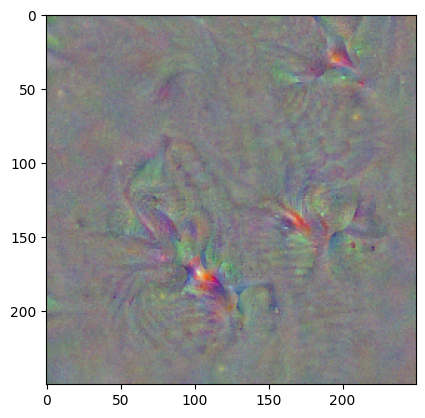

In [342]:
plt.imshow(processed_image.T)

In [6]:
model

ModelWithActivations(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)